In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Fix timezone mismatch by normalizing timestamps to tz-naive before computing age
import os, re, math, joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor

In [4]:
PROJ = r"C:\Users\PC\Desktop\practice\testing/udemy_portfolio_project"
FIGS = os.path.join(PROJ, "figs")
MODELS = os.path.join(PROJ, "models")
RESULTS = os.path.join(PROJ, "results")
SCRIPTS = os.path.join(PROJ, "scripts")
os.makedirs(FIGS, exist_ok=True)
os.makedirs(MODELS, exist_ok=True)
os.makedirs(RESULTS, exist_ok=True)
os.makedirs(SCRIPTS, exist_ok=True)

In [5]:
file_path = r"C:\Users\PC\Downloads\Udemy Courses.csv"
df_raw = pd.read_csv(file_path)

In [6]:
df = df_raw.copy()
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

In [6]:
df.to_csv(os.path.join(PROJ, "udemy_courses_raw_snapshot.csv"), index=False)

In [7]:
df.head()

,course_id,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,288942,#1 Piano Hand Coordination: Play 10th Ballad i...,True,35,3137,18,68,All Levels,1.5 hours,2014-09-18T05:07:05Z,Musical Instruments
1,1170074,#10 Hand Coordination - Transfer Chord Ballad ...,True,75,1593,1,41,Intermediate Level,1 hour,2017-04-12T19:06:34Z,Musical Instruments
2,1193886,#12 Hand Coordination: Let your Hands dance wi...,True,75,482,1,47,Intermediate Level,1.5 hours,2017-04-26T18:34:57Z,Musical Instruments
3,1116700,#4 Piano Hand Coordination: Fun Piano Runs in ...,True,75,850,3,43,Intermediate Level,1 hour,2017-02-21T23:48:18Z,Musical Instruments
4,1120410,#5 Piano Hand Coordination: Piano Runs in 2 ...,True,75,940,3,32,Intermediate Level,37 mins,2017-02-21T23:44:49Z,Musical Instruments


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   course_id            3682 non-null   int64 
 1   course_title         3682 non-null   object
 2   is_paid              3682 non-null   bool  
 3   price                3682 non-null   object
 4   num_subscribers      3682 non-null   int64 
 5   num_reviews          3682 non-null   int64 
 6   num_lectures         3682 non-null   int64 
 7   level                3682 non-null   object
 8   content_duration     3682 non-null   object
 9   published_timestamp  3682 non-null   object
 10  subject              3682 non-null   object
dtypes: bool(1), int64(4), object(6)
memory usage: 291.4+ KB


In [9]:
df.subject.unique()

array(['Musical Instruments', 'Business Finance', 'Graphic Design',
       'Web Development'], dtype=object)

In [10]:
df.level.unique()

array(['All Levels', 'Intermediate Level', 'Beginner Level',
       'Expert Level'], dtype=object)

In [11]:
df.subject.value_counts()

subject
Web Development        1200
Business Finance       1199
Musical Instruments     680
Graphic Design          603
Name: count, dtype: int64

In [12]:
df.is_paid.value_counts()

is_paid
True     3372
False     310
Name: count, dtype: int64

In [13]:
len(df[df.course_title.str.contains('Python', case = True)])

29

In [14]:
# Timestamp fix
if "published_timestamp" in df.columns:
    dt = pd.to_datetime(df["published_timestamp"], errors="coerce", utc=True)
elif "published_time" in df.columns:
    dt = pd.to_datetime(df["published_time"], errors="coerce", utc=True)
else:
    dt = pd.Series([pd.NaT]*len(df))
df["published_timestamp"] = dt.dt.tz_convert(None)

In [15]:
# Price numeric + is_paid
if "price" in df.columns:
    df["price"] = (
        df["price"].astype(str).str.replace(r"[^0-9.]", "", regex=True).replace({"": np.nan}).astype(float)
    )
if "is_paid" in df.columns and "price" in df.columns:
    df.loc[df["is_paid"] == False, "price"] = 0.0

In [16]:
# Content duration numeric
if "content_duration" in df.columns:
    def _to_float_hours(x):
        if pd.isna(x): return np.nan
        if isinstance(x, (int, float)): return float(x)
        m = re.search(r"(\d+(\.\d+)?)", str(x).lower())
        return float(m.group(1)) if m else np.nan
    df["content_duration"] = df["content_duration"].apply(_to_float_hours)

In [17]:
# Numeric conversions
for col in ["num_subscribers","num_reviews","num_lectures"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [18]:
# Time features
now = pd.Timestamp.utcnow().tz_localize(None)
df["course_age_days"] = (now - df["published_timestamp"]).dt.days
df["pub_year"] = df["published_timestamp"].dt.year
df["pub_month"] = df["published_timestamp"].dt.month
df["pub_dow"] = df["published_timestamp"].dt.dayofweek

In [20]:
# Impute
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())
for c in df.select_dtypes(exclude=[np.number]).columns:
    df[c] = df[c].fillna("Unknown")

In [21]:
# Targets
if "num_subscribers" not in df.columns:
    raise ValueError("num_subscribers not found.")
thr = np.nanpercentile(df["num_subscribers"], 75)
df["popular"] = (df["num_subscribers"] >= thr).astype(int)

In [23]:
# Features
feat = [c for c in ["price","num_reviews","num_lectures","content_duration","course_age_days","pub_year","pub_month","pub_dow","is_paid","subject","level"] if c in df.columns]
X = pd.get_dummies(df[feat], columns=[c for c in ["subject","level"] if c in df.columns], drop_first=True)
y_class = df["popular"].copy()
y_reg = df["num_subscribers"].copy()

In [22]:
df.head(3)

,course_id,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,course_age_days,pub_year,pub_month,pub_dow,popular
0,288942,#1 Piano Hand Coordination: Play 10th Ballad i...,True,35.0,3137,18,68,All Levels,1.5,2014-09-18 05:07:05,Musical Instruments,3982,2014,9,3,1
1,1170074,#10 Hand Coordination - Transfer Chord Ballad ...,True,75.0,1593,1,41,Intermediate Level,1.0,2017-04-12 19:06:34,Musical Instruments,3044,2017,4,2,0
2,1193886,#12 Hand Coordination: Let your Hands dance wi...,True,75.0,482,1,47,Intermediate Level,1.5,2017-04-26 18:34:57,Musical Instruments,3030,2017,4,2,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   course_id            3682 non-null   int64         
 1   course_title         3682 non-null   object        
 2   is_paid              3682 non-null   bool          
 3   price                3682 non-null   float64       
 4   num_subscribers      3682 non-null   int64         
 5   num_reviews          3682 non-null   int64         
 6   num_lectures         3682 non-null   int64         
 7   level                3682 non-null   object        
 8   content_duration     3682 non-null   float64       
 9   published_timestamp  3682 non-null   datetime64[ns]
 10  subject              3682 non-null   object        
 11  course_age_days      3682 non-null   int64         
 12  pub_year             3682 non-null   int32         
 13  pub_month            3682 non-nul

In [36]:
#df['is_paid'] = df['is_paid'].astype(int)
#df.head(1)

In [27]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, stratify=y_class, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)

In [28]:
# Scale
scaler = StandardScaler()
cols = X.columns.tolist()
X_train_c[cols] = scaler.fit_transform(X_train_c[cols]); X_test_c[cols] = scaler.transform(X_test_c[cols])
X_train_r[cols] = scaler.fit_transform(X_train_r[cols]); X_test_r[cols] = scaler.transform(X_test_r[cols])

In [29]:
# Classification
cls_models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cls_rows = []
best_name, best_model, best_f1 = None, None, -1
for name, model in cls_models.items():
    cv_acc = cross_val_score(model, X_train_c, y_train_c, cv=skf, scoring="accuracy").mean()
    cv_f1 = cross_val_score(model, X_train_c, y_train_c, cv=skf, scoring="f1").mean()
    model.fit(X_train_c, y_train_c)
    pred = model.predict(X_test_c)
    proba = model.predict_proba(X_test_c)[:,1] if hasattr(model, "predict_proba") else None
    acc = accuracy_score(y_test_c, pred); prec = precision_score(y_test_c, pred); rec = recall_score(y_test_c, pred); f1 = f1_score(y_test_c, pred)
    roc = roc_auc_score(y_test_c, proba) if proba is not None else np.nan
    cls_rows.append({"Model": name, "CV_Accuracy": round(cv_acc,4), "CV_F1": round(cv_f1,4), "Test_Accuracy": round(acc,4),
                     "Precision": round(prec,4), "Recall": round(rec,4), "F1": round(f1,4), "ROC_AUC": round(roc,4) if not math.isnan(roc) else None})
    if f1 > best_f1:
        best_f1, best_model, best_name = f1, model, name

cls_df = pd.DataFrame(cls_rows).sort_values(by="F1", ascending=False).reset_index(drop=True)
cls_df.to_csv(os.path.join(RESULTS, "classification_results.csv"), index=False)

In [30]:
# Regression
reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=400, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
reg_rows = []
best_reg, best_reg_name, best_mae = None, None, 1e9
for name, model in reg_models.items():
    cv_mae = -cross_val_score(model, X_train_r, y_train_r, cv=kf, scoring="neg_mean_absolute_error").mean()
    cv_r2 = cross_val_score(model, X_train_r, y_train_r, cv=kf, scoring="r2").mean()
    model.fit(X_train_r, y_train_r)
    pred = model.predict(X_test_r)
    mae = mean_absolute_error(y_test_r, pred); rmse = mean_squared_error(y_test_r, pred, squared=False); r2 = r2_score(y_test_r, pred)
    reg_rows.append({"Model": name, "CV_MAE": round(cv_mae,2), "CV_R2": round(cv_r2,3), "Test_MAE": round(mae,2), "Test_RMSE": round(rmse,2), "Test_R2": round(r2,3)})
    if mae < best_mae:
        best_mae, best_reg, best_reg_name = mae, model, name
reg_df = pd.DataFrame(reg_rows).sort_values(by="Test_MAE", ascending=True).reset_index(drop=True)
reg_df.to_csv(os.path.join(RESULTS, "regression_results.csv"), index=False)

C:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


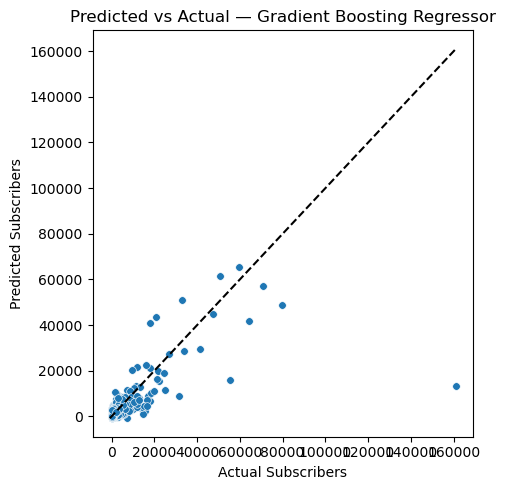

In [32]:
pred = best_reg.predict(X_test_r)
plt.figure(figsize=(5,5)); sns.scatterplot(x=y_test_r, y=pred, s=30)
lims = [min(y_test_r.min(), pred.min()), max(y_test_r.max(), pred.max())]
plt.plot(lims, lims, 'k--')
plt.xlabel("Actual Subscribers"); plt.ylabel("Predicted Subscribers")
plt.title(f"Predicted vs Actual — {best_reg_name}"); plt.tight_layout()
plt.savefig(os.path.join(FIGS, f'pred_vs_actual_{best_reg_name.replace(" ","_").lower()}.png')); plt.show()

In [33]:
# Save models & scaler
joblib.dump(best_model, os.path.join(MODELS, f"best_classifier_{best_name.replace(' ','_').lower()}.joblib"))
joblib.dump(best_reg, os.path.join(MODELS, f"best_regressor_{best_reg_name.replace(' ','_').lower()}.joblib"))
joblib.dump(scaler, os.path.join(MODELS, "scaler.joblib"))

['C:\\Users\\PC\\Desktop\\practice\\testing/udemy_portfolio_project\\models\\scaler.joblib']

In [34]:
# Summaries
summary = {
    "classification_top": cls_df.head(3).to_dict(orient="records"),
    "regression_top": reg_df.head(3).to_dict(orient="records"),
    "best_classifier": best_name,
    "best_regressor": best_reg_name,
    "project_dir": PROJ
}

In [41]:
import json

PROJ = r"C:\Users\PC\Desktop\practice\testing/udemy_portfolio_project"
def safe_ls(p):
    try:
        return os.listdir(p)
    except Exception as e:
        return [str(e)]
        
inventory = {
    "project_dir": PROJ,
    "subdirs": safe_ls(PROJ),
    "figs": safe_ls(f"{PROJ}/figs"),
    "models": safe_ls(f"{PROJ}/models"),
    "results": safe_ls(f"{PROJ}/results"),
    "scripts": safe_ls(f"{PROJ}/scripts"),
    "readme_exists": os.path.exists(f"{PROJ}/README.md")
}
inventory

{'project_dir': 'C:\\Users\\PC\\Desktop\\practice\\testing/udemy_portfolio_project',
 'subdirs': ['figs', 'models', 'README.md', 'results', 'scripts'],
 'figs': ['pred_vs_actual_gradient_boosting_regressor.png'],
 'models': ['best_classifier_random_forest.joblib',
  'best_regressor_gradient_boosting_regressor.joblib',
  'scaler.joblib'],
 'results': ['classification_results.csv', 'regression_results.csv'],
 'scripts': ['udemy_ml_project.py'],
 'readme_exists': True}

In [42]:
import os, textwrap

PROJ = r"C:\Users\PC\Desktop\practice\testing/udemy_portfolio_project"
FIGS = os.path.join(PROJ, "figs")
RESULTS = os.path.join(PROJ, "results")
MODELS = os.path.join(PROJ, "models")
SCRIPTS = os.path.join(PROJ, "scripts")
os.makedirs(SCRIPTS, exist_ok=True)

readme = """# Udemy Courses — End-to-End ML Project (Portfolio)"""

with open(os.path.join(PROJ, "README.md"), "w", encoding="utf-8") as f:
    f.write(readme)

script = '''# scripts/udemy_ml_project.py'''

with open(os.path.join(SCRIPTS, "udemy_ml_project.py"), "w", encoding="utf-8") as f:
    f.write(script)
{"readme_path": os.path.join(PROJ, "README.md"),
 "script_path": os.path.join(SCRIPTS, "udemy_ml_project.py")}

{'readme_path': 'C:\\Users\\PC\\Desktop\\practice\\testing/udemy_portfolio_project\\README.md',
 'script_path': 'C:\\Users\\PC\\Desktop\\practice\\testing/udemy_portfolio_project\\scripts\\udemy_ml_project.py'}

In [43]:
# Create a zip archive of the entire project directory for easy download
import os, zipfile

PROJ = r"C:\Users\PC\Desktop\practice\testing/udemy_portfolio_project"
ZIP_PATH = r"C:\Users\PC\Desktop\practice\testing/udemy_portfolio_project.zip"

def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            fpath = os.path.join(root, file)
            arcname = os.path.relpath(fpath, start=os.path.dirname(path))
            ziph.write(fpath, arcname)

with zipfile.ZipFile(ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir(PROJ, zipf)

ZIP_PATH

'C:\\Users\\PC\\Desktop\\practice\\testing/udemy_portfolio_project.zip'